In [1]:
using Pkg
using Conda
using WebIO
using Interact
using DifferentialEquations
using DiffEqFlux
using DiffEqSensitivity, OrdinaryDiffEq, Zygote
using Plots
using Lux, Optim, Test
using Optimization, OptimizationPolyalgorithms

using BifurcationKit
using Revise
using SparseArrays, LinearAlgebra, DiffEqOperators, Setfield, Parameters
using GaussianProcesses
using Distributions,Random
using ForwardDiff
using MAT
using CSV
using DataFrames

using DataDrivenDiffEq
using ModelingToolkit
using Surrogates,SurrogatesAbstractGPs
using ReservoirComputing

gr()

WebIO._IJuliaInit()

┌ Warning: OrcV2 initialization failed with
│   err = ErrorException("could not load library \"C:\\Users\\周天恒\\.julia\\artifacts\\12030a5c187a7e327b57d45e3397edf672ab442d\\bin\\libLLVMExtra-12.dll\"\nThe specified procedure could not be found. ")
└ @ Enzyme.Compiler.JIT C:\Users\周天恒\.julia\packages\Enzyme\di3zM\src\compiler\orcv2.jl:103
┌ Info: DataDrivenDiffEq : OccamNet is available.
└ @ DataDrivenDiffEq C:\Users\周天恒\.julia\packages\DataDrivenDiffEq\s9jl3\src\DataDrivenDiffEq.jl:168


Plots.GRBackend()

## 1. Suppose we know exactly the seventh order solution and the third order solution, we can train a NN to approximate the residual between them. So that the true solution can be represented by the third order solution + the NN(x,t)

### (1) train with simple NNs to see the effect (without noise), with cross validation.

### (2) If the NN gets stuck, try multiple shoot.

In [2]:
function Duffing(u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y = u
    du1 = y
    du2 = -b*y - wn_2*x - mu*x^3 - v*x^5 - rho*x^7 + delta_st * wn_2 * cos(w*t)
    du = [du1,du2]
end

function Duffing_Approx(u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y = u
    du1 = y
    #there is no v and rho
    du2 = -b*y - wn_2*x - mu*x^3 + delta_st * wn_2 * cos(w*t)
    du = [du1,du2]
end

Duffing_Approx (generic function with 1 method)

In [3]:
initial_1 = [1.0,0.0]
datasize_1 = 30
timespan_1 = (0.0,10.0)
t_1 = range(timespan_1[1],timespan_1[2],length=datasize_1)
param_1 = [0.5,1.0,1.5,-1.0,0.05,1.0,round(2*pi*20,digits = 3)]

prob_Duffing = ODEProblem(Duffing,initial_1,timespan_1,param_1)
sol_Duffing = Array(solve(prob_Duffing,Tsit5(),saveat=t_1))

prob_Duffing_A = ODEProblem(Duffing_Approx,initial_1,timespan_1,param_1)
sol_Duffing_A = Array(solve(prob_Duffing_A,Tsit5(),saveat=t_1))

2×30 Matrix{Float64}:
 1.0   0.866676   0.557655   0.205323  …  -0.0941449  -0.0607524  -0.0260284
 0.0  -0.718126  -1.01852   -1.0081        0.0983926   0.105864    0.098612

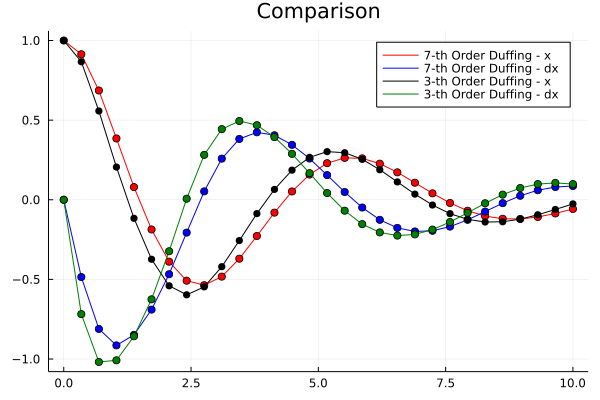

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [4]:
plot(t_1,sol_Duffing[1,:],color = "red",label = "7-th Order Duffing - x")
scatter!(t_1,sol_Duffing[1,:],color = "red",label = "")
plot!(t_1,sol_Duffing[2,:],color = "blue",label = "7-th Order Duffing - dx")
scatter!(t_1,sol_Duffing[2,:],color = "blue",label = "",title = "Comparison")


plot!(t_1,sol_Duffing_A[1,:],color = "black",label = "3-th Order Duffing - x")
scatter!(t_1,sol_Duffing_A[1,:],color = "black",label = "")
plot!(t_1,sol_Duffing_A[2,:],color = "green",label = "3-th Order Duffing - dx")
scatter!(t_1,sol_Duffing_A[2,:],color = "green",label = "",title = "Comparison")

## 1.1 Approximate 7-th, 3-th only with derivative, approximate the residual (without noise)
[Introduction to Scientific Machine Learning through Physics-Informed Neural Networks](https://book.sciml.ai/notes/03/)


Universal Approximate Theory

0.37338596904307336

0.00013449886112112898

3.7396601762062664e-5

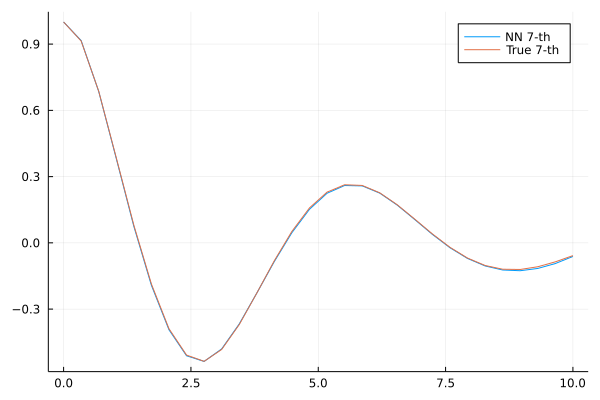

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [5]:
NNODE = Flux.Chain(x -> [x],
           Flux.Dense(1,32,tanh),
           Flux.Dense(32,1),
           first)

g(t) = t*NNODE(t) + initial_1[1]
ϵ = sqrt(eps(Float32))
loss() = mean(([(g(t+ϵ)-g(t))/ϵ for t in t_1] .- sol_Duffing[2,:]).^2) 

#+ 0.1* mean((NNODE.(t_1) .- sol_Duffing[1,:]).^2)

opt = Flux.Adam(0.05)
data = Iterators.repeated((), 1000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(loss())
  end
end
display(loss())
Flux.train!(loss, Flux.params(NNODE), data, opt; cb=cb)

p1 = plot()
plot!(p1,t_1,g.(t_1),label = "NN 7-th")
plot!(p1,t_1,sol_Duffing[1,:],label = "True 7-th")


1.3523930694280653

0.0001522360445817018

6.37308734839758e-5

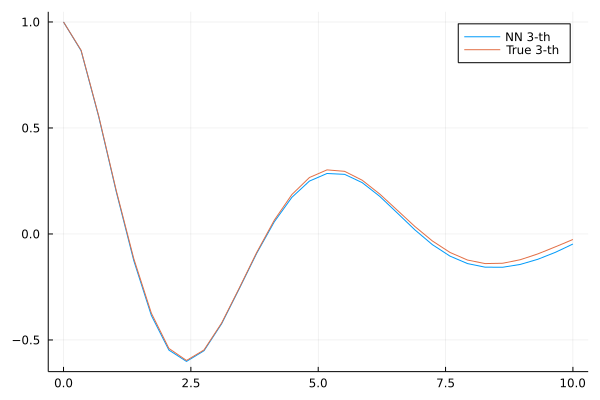

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [6]:
NNODE = Flux.Chain(x -> [x],
           Flux.Dense(1,32,tanh),
           Flux.Dense(32,1),
           first)

g(t) = t*NNODE(t) + initial_1[1]
ϵ = sqrt(eps(Float32))
loss() = mean(([(g(t+ϵ)-g(t))/ϵ for t in t_1] .- sol_Duffing_A[2,:]).^2) 

opt = Flux.Adam(0.05)
data = Iterators.repeated((), 1000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(loss())
  end
end
display(loss())
Flux.train!(loss, Flux.params(NNODE), data, opt; cb=cb)

p2 = plot()
plot!(p2,t_1,g.(t_1),label = "NN 3-th")
plot!(p2,t_1,sol_Duffing_A[1,:],label = "True 3-th")


In [7]:
NNODE = Flux.Chain(x -> [x],
           Flux.Dense(1,32,tanh),
           Flux.Dense(32,1),
           first)

g(t) = t*NNODE(t) + initial_1[1]
ϵ = sqrt(eps(Float32))
loss() = mean(abs2.(NNODE.(t_1)-(sol_Duffing[1,:] - sol_Duffing_A[1,:]))) 
#+  mean(abs2.(NNODE.(t_1)-(sol_Duffing[2,:] - sol_Duffing_A[2,:])))

opt = Flux.Adam(0.05)
data = Iterators.repeated((), 1000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(loss())
  end
end
display(loss())
Flux.train!(loss, Flux.params(NNODE), data, opt; cb=cb)


0.010488464575421564

0.0022710318609278344

0.000966427523094858

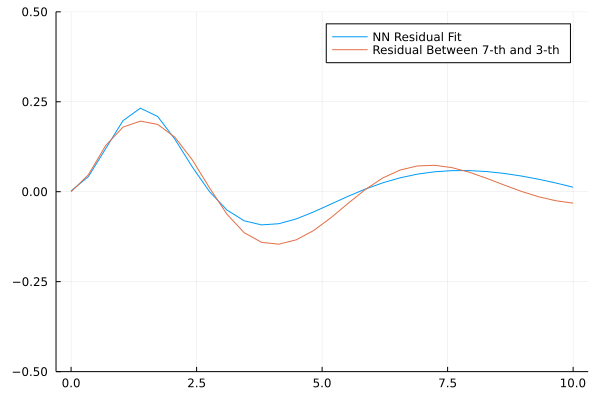

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [8]:
p3 = plot(ylim = [-0.5,0.5])
plot!(p3,t_1,NNODE.(t_1),label = "NN Residual Fit")
plot!(p3,t_1,sol_Duffing[1,:]-sol_Duffing_A[1,:],label = "Residual Between 7-th and 3-th")
#plot!(p3,0:0.01:10.0,NNODE.(0:0.01:10.0))

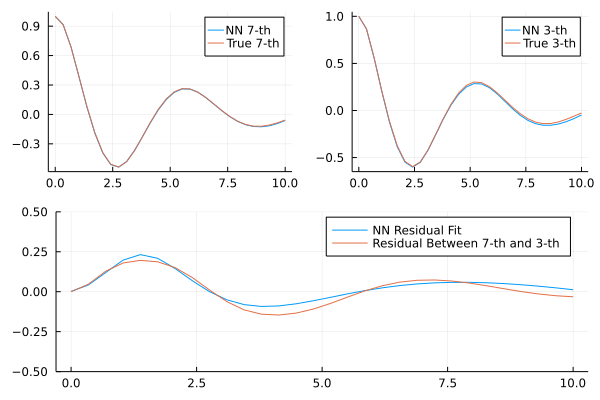

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [9]:
l = @layout [a b;c]
plot(p1,p2,p3,layout = l)

## 1.2 Combine with the Physics theory

In [10]:
function Duffing_seventh(u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y,u1,u2 = u
    out = similar(u)
    out[1] = y
    out[2] = -b*y - wn_2*x - mu*x^3 - v*x^5 - rho*x^7 + delta_st * wn_2 * u1
    out[3] = u1 + w*u2 - u1*(u1^2+u2^2)
    out[4] = -w*u1 + u2 - u2*(u1^2+u2^2)
    out
end

function Duffing_seventh(u,p)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y,u1,u2 = u
    out = similar(u)
    out[1] = y
    out[2] = -b*y - wn_2*x - mu*x^3 - v*x^5 - rho*x^7 + delta_st * wn_2 * u1
    out[3] = u1 + w*u2 - u1*(u1^2+u2^2)
    out[4] = -w*u1 + u2 - u2*(u1^2+u2^2)
    out
end


function Duffing_third(u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y,u1,u2 = u
    out = similar(u)
    out[1] = y
    out[2] = -b*y - wn_2*x - mu*x^3 + delta_st * wn_2 * u1
    out[3] = u1 + w*u2 - u1*(u1^2+u2^2)
    out[4] = -w*u1 + u2 - u2*(u1^2+u2^2)
    out
end


function Duffing_third(u,p)
    b,wn_2,mu,v,rho,delta_st,w = p
    x,y,u1,u2 = u
    out = similar(u)
    out[1] = y
    out[2] = -b*y - wn_2*x - mu*x^3 + delta_st * wn_2 * u1
    out[3] = u1 + w*u2 - u1*(u1^2+u2^2)
    out[4] = -w*u1 + u2 - u2*(u1^2+u2^2)
    out
end

Duffing_third (generic function with 2 methods)

In [11]:
function generate_data_with_noise_and_initial(initial_condition, datasize, timespan, ODE_parameter,ODE_function,noise_sigma=0)
    t = range(timespan[1],timespan[2],length=datasize)
    prob = ODEProblem(ODE_function,initial_condition,timespan,ODE_parameter)
    sol = Array(solve(prob,Tsit5(),saveat=t))
    noise = rand(Normal(0,noise_sigma),datasize)
    original_sol = copy(sol)
    sol[1,:] = sol[1,:] + noise
    return (original_sol,sol)
end

generate_data_with_noise_and_initial (generic function with 2 methods)

In [12]:
noise_level = [0.0,0.1,0.2,0.4]
initial_condition1 = [1.0,0.0,1.0,0.0]
datasize = 30
timespan = (0.0,12.0)
ODE_parameter = [0.3159,1.0,1.499,-0.3921,0.0422,1.0,round(2*pi*19.95,digits = 3)]

7-element Vector{Float64}:
   0.3159
   1.0
   1.499
  -0.3921
   0.0422
   1.0
 125.35

In [13]:
#Duffing Seventh data
data_0,data_0_noise = generate_data_with_noise_and_initial(
    initial_condition1,datasize,timespan,ODE_parameter,Duffing_seventh,noise_level[1])
data_1,data_1_noise = generate_data_with_noise_and_initial(
    initial_condition1,datasize,timespan,ODE_parameter,Duffing_seventh,noise_level[2])
data_2,data_2_noise = generate_data_with_noise_and_initial(
    initial_condition1,datasize,timespan,ODE_parameter,Duffing_seventh,noise_level[3])
data_3,data_3_noise = generate_data_with_noise_and_initial(
    initial_condition1,datasize,timespan,ODE_parameter,Duffing_seventh,noise_level[4])

([1.0 0.8329008676794839 … 0.17341767705009556 0.12432531851032154; 0.0 -0.7411678516389076 … -0.08480669987209075 -0.1375919263960941; 1.0 -0.038541989624664486 … 0.4530877188507473 -0.9156225390352747; 0.0 -1.0023922219908676 … -0.89844031185603 -0.41713808938488606], [0.6658506251200215 1.0658391549628508 … 0.6040482896347114 -0.09021024549638133; 0.0 -0.7411678516389076 … -0.08480669987209075 -0.1375919263960941; 1.0 -0.038541989624664486 … 0.4530877188507473 -0.9156225390352747; 0.0 -1.0023922219908676 … -0.89844031185603 -0.41713808938488606])

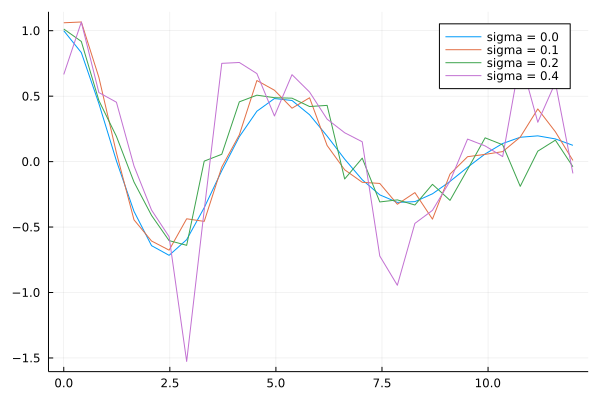

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [14]:
plot(range(timespan[1],timespan[2],length=datasize),data_0_noise[1,:],label = "sigma = $(noise_level[1])")

plot!(range(timespan[1],timespan[2],length=datasize),data_1_noise[1,:],label = "sigma = $(noise_level[2])")
plot!(range(timespan[1],timespan[2],length=datasize),data_2_noise[1,:],label = "sigma = $(noise_level[3])")
plot!(range(timespan[1],timespan[2],length=datasize),data_3_noise[1,:],label = "sigma = $(noise_level[4])")

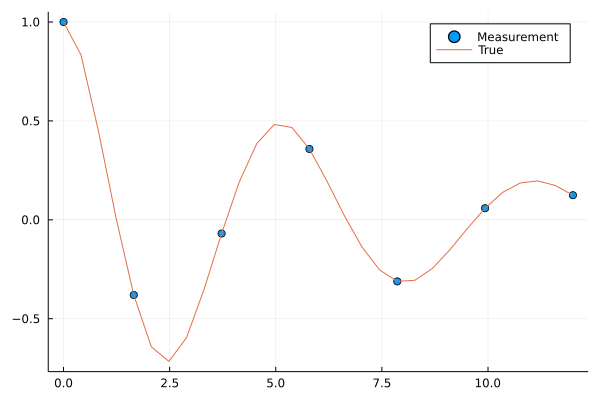

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [15]:
sample_t = range(timespan[1],timespan[2],length=datasize)[[1,5,10,15,20,25,30]]
sample_data_0 = data_0[:,[1,5,10,15,20,25,30]]

scatter(sample_t,sample_data_0[1,:],label = "Measurement")
plot!(range(timespan[1],timespan[2],length=datasize),data_0[1,:],label = "True")

In [16]:
function Duffing_seventh1(du,u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    
    out = -b*du - wn_2*u - mu*u^3 - v*u^5 - rho*u^7 + delta_st * wn_2 * cos(w*t)
end

Duffing_seventh1 (generic function with 1 method)

In [17]:
sol = solve(SecondOrderODEProblem(Duffing_seventh1,1.0,0.0,(0.0,10.0),ODE_parameter))

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 354-element Vector{Float64}:
  0.0
  0.0009990007657052634
  0.007092857309571885
  0.017149855625996108
  0.029350413830973768
  0.04510115641122994
  0.06427086250606291
  0.08565338768068584
  0.1086319301588016
  0.1335653072607032
  0.1600873114626763
  0.18793054996759775
  0.21719566197388862
  ⋮
  9.82324979478675
  9.843816867552604
  9.863526490699835
  9.87871296430262
  9.894401938709557
  9.913019704617653
  9.927775696564279
  9.943933754522954
  9.96547949996385
  9.98145631741802
  9.999183666351046
 10.0
u: 354-element Vector{ArrayPartition{Float64, Tuple{Float64, Float64}}}:
 (1.0, 0.0)
 (1.0006802008590359, 0.0009993412786849616)
 (1.0039239117984244, 0.007108379942748892)
 (1.0010964623692304, 0.017200899454858646)
 (0.9862194145025269, 0.029328194253663772)
 (0.9801390729235019, 0.0447772805508132)
 (0.985643010937848, 0.0636542649600905)
 (0.9619503951091939, 0.08447912778619694)
 (0.967

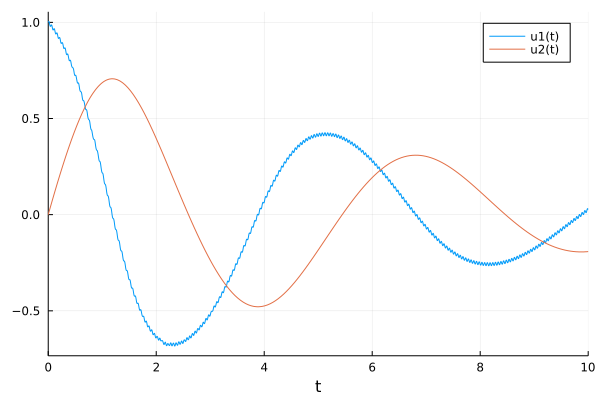

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [18]:
plot(sol)

In [19]:
plot_t = 0:0.1:10
data_plot = sol(plot_t)
positions_plot = [state[2] for state in data_plot]

state_2 = [state[2] for state in data_plot]
state_1 = [state[1] for state in data_plot]

101-element Vector{Float64}:
  1.0
  0.9636503022290818
  0.9189895738594092
  0.865731182651033
  0.8018470020538504
  0.7242974931008588
  0.6400591487213458
  0.5461205797298412
  0.4410472946188575
  0.33482659231045525
  0.21754224133251268
  0.09905158150870068
 -0.019374681513764
  ⋮
 -0.19619480675206588
 -0.17967550401374446
 -0.1612328598010505
 -0.141879188217774
 -0.12177536040772437
 -0.1009148611253901
 -0.07956957242927423
 -0.05801130162530545
 -0.03648241243037211
 -0.015255786424334944
  0.0056258254952583206
  0.025789312378241513

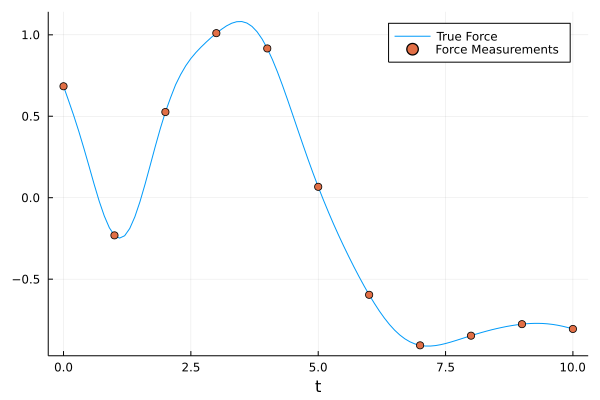

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [20]:
force_plot = [Duffing_seventh1(state_1[i],state_2[i],ODE_parameter,plot_t[i]) for i in 1:length(plot_t)]

# Generate the dataset
t = 0:1:10
dataset = sol(t)
position_data = [state[2] for state in sol(t)]
s_1 = [state[1] for state in sol(t)]
force_data = [Duffing_seventh1(s_1[i],position_data[i],ODE_parameter,t[i]) for i in 1:length(t)]

plot(plot_t,force_plot,xlabel="t",label="True Force")
scatter!(t,force_data,label="Force Measurements")

In [21]:
NNForce = Flux.Chain(x -> [x],
           Flux.Dense(1,32,tanh),
           Flux.Dense(32,1),
           first)

Chain(
  var"#31#32"(),
  Dense(1 => 32, tanh),                 # 64 parameters
  Dense(32 => 1),                       # 33 parameters
  first,
)                   # Total: 4 arrays, 97 parameters, 644 bytes.

In [22]:
loss() = sum(abs2,NNForce(position_data[i]) - force_data[i] for i in 1:length(position_data))
loss()

5.385945461655993

In [23]:
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 2000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(loss())
  end
end
display(loss())
Flux.train!(loss, Flux.params(NNForce), data, opt; cb=cb)

5.385945461655993

5.026297721642612

4.252994188168347

4.092228121233937

4.089445110361112

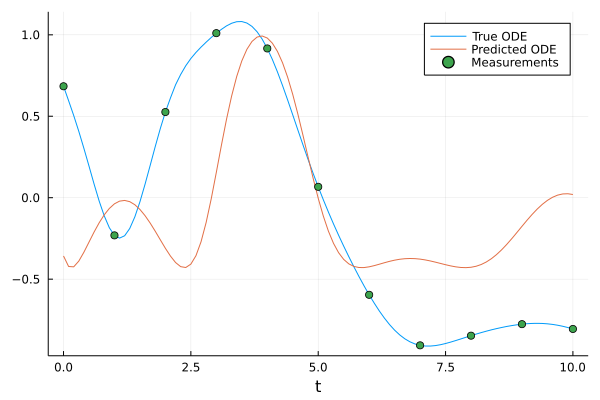

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [24]:
learned_force_plot = NNForce.(positions_plot)

plot(plot_t,force_plot,xlabel="t",label="True ODE")
plot!(plot_t,learned_force_plot,label="Predicted ODE")
scatter!(t,force_data,label="Measurements")

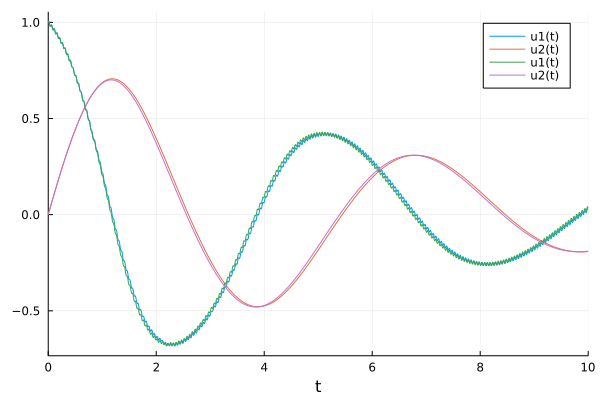

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [25]:
function Duffing_third1(du,u,p,t)
    b,wn_2,mu,v,rho,delta_st,w = p
    
    out = -b*du - wn_2*u - mu*u^3 + delta_st * wn_2 * cos(w*t)
end


prob_simplified = SecondOrderODEProblem(Duffing_third1,1.0,0.0,(0.0,10.0),ODE_parameter)
sol_simplified = solve(prob_simplified)
plot(sol)
plot!(sol_simplified)

In [26]:
random_positions = [2rand()-1 for i in 1:100] # random values in [-1,1]
loss_ode() = sum(abs2,NNForce(x) - (-1.0*x-1.499*x^3+0.3921*x^5-0.0422*x^7) for x in random_positions)
loss_ode()

54.527716340241454

In [27]:
ODE_parameter

7-element Vector{Float64}:
   0.3159
   1.0
   1.499
  -0.3921
   0.0422
   1.0
 125.35

In [28]:
λ = 0.1
composed_loss() = loss() + λ*loss_ode()

composed_loss (generic function with 1 method)

9.542216744385257

4.881799549565882

4.470376771522052

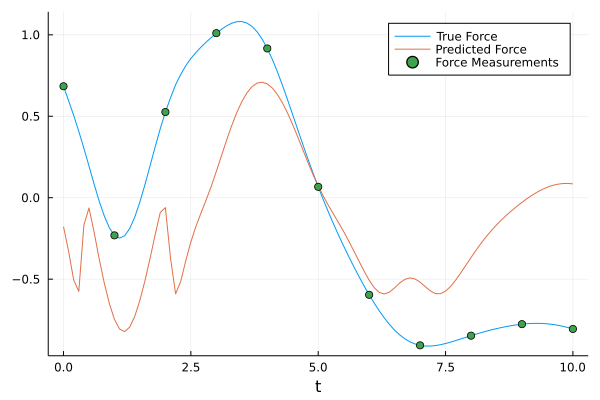

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [29]:
opt = Flux.Adam(0.05)
data = Iterators.repeated((), 1000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(composed_loss())
  end
end
display(composed_loss())
Flux.train!(composed_loss, Flux.params(NNForce), data, opt; cb=cb)

learned_force_plot = NNForce.(positions_plot)

plot(plot_t,force_plot,xlabel="t",label="True Force")
plot!(plot_t,learned_force_plot,label="Predicted Force")
scatter!(t,force_data,label="Force Measurements")

In [30]:
using Surrogates
using Plots
default()
using AbstractGPs #required to access different types of kernels
using SurrogatesAbstractGPs

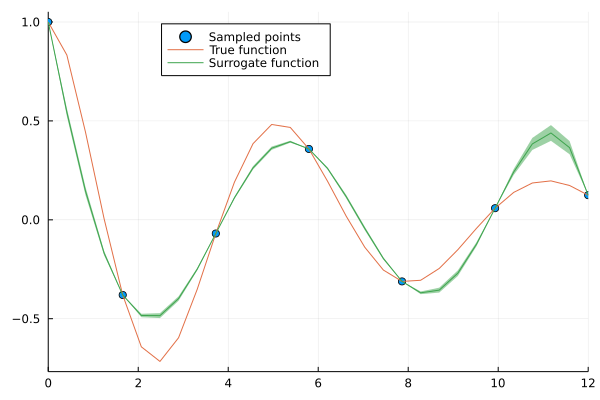

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [31]:
kriging_surrogate = Kriging(sample_t, sample_data_0[1,:], 0.0, 12.0);
t_k = range(timespan[1],timespan[2],length=datasize)
plot(sample_t, sample_data_0[1,:], seriestype=:scatter, label="Sampled points", xlims=(0, 12), legend=:top)
plot!(t_k, data_0[1,:], label="True function", legend=:top)
plot!(t_k, kriging_surrogate.(t_k), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)




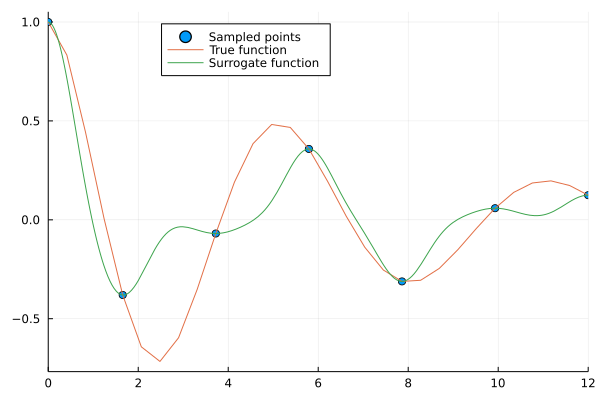

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [32]:
lobachevsky_surrogate = LobachevskySurrogate(sample_t, sample_data_0[1,:], 0,12, alpha = 2.0, n = 6)
plot(sample_t, sample_data_0[1,:], seriestype=:scatter, label="Sampled points", xlims=(0, 12), legend=:top)
plot!(t_k, data_0[1,:], label="True function", legend=:top)
plot!(lobachevsky_surrogate, label="Surrogate function")

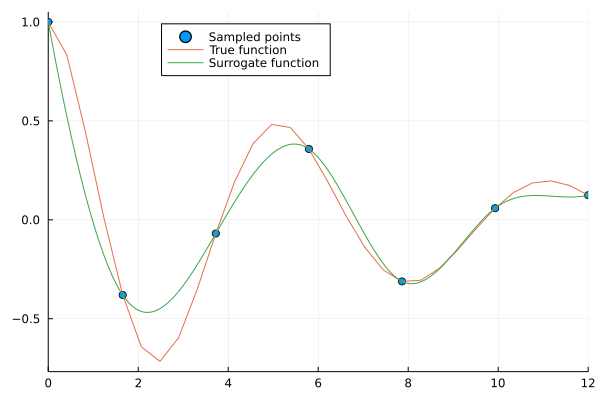

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [33]:
radial_surrogate = RadialBasis(sample_t, sample_data_0[1,:], 0,12, rad = cubicRadial())

plot(sample_t, sample_data_0[1,:], seriestype=:scatter, label="Sampled points", xlims=(0, 12), legend=:top)
plot!(t_k, data_0[1,:], label="True function", legend=:top)
plot!(radial_surrogate, label="Surrogate function")

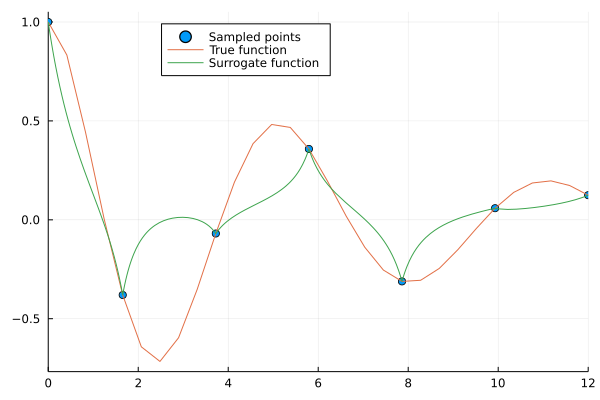

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [34]:
InverseDistance = InverseDistanceSurrogate(sample_t, sample_data_0[1,:], 0,12)


plot(sample_t, sample_data_0[1,:], seriestype=:scatter, label="Sampled points", xlims=(0, 12), legend=:top)
plot!(t_k, data_0[1,:], label="True function", legend=:top)
plot!(InverseDistance, label="Surrogate function", legend=:top)

## Echo State NN

In [35]:
data_ESN,data_ESN_noise = generate_data_with_noise_and_initial(
    [1.0,0.0],60,timespan,ODE_parameter,Duffing,noise_level[1])

([1.0 0.9570436189021665 … 0.15254008424230217 0.12571885657949286; 0.0 -0.4096512446710694 … -0.11425772920601845 -0.13708278414038474], [1.0 0.9570436189021665 … 0.15254008424230217 0.12571885657949286; 0.0 -0.4096512446710694 … -0.11425772920601845 -0.13708278414038474])

In [36]:
data_ESN

2×60 Matrix{Float64}:
 1.0   0.957044   0.838105   0.664677  …   0.17442     0.15254    0.125719
 0.0  -0.409651  -0.731651  -0.941077     -0.0853641  -0.114258  -0.137083

In [37]:
shift = 10
train_len = 40
predict_len = 10
t_esn = range(timespan[1],timespan[2],length=60)

#split the data accordingly
input_data = data_ESN[:, shift:shift+train_len-1]
t_input = t_esn[shift:shift+train_len-1]

target_data = data_ESN[:, shift+1:shift+train_len]
t_target = t_esn[shift+1:shift+train_len]


test_data = data_ESN[:,shift+train_len+1:shift+train_len+predict_len]
t_test = t_esn[shift+train_len+1:shift+train_len+predict_len]

10.169491525423728:0.2033898305084746:12.0

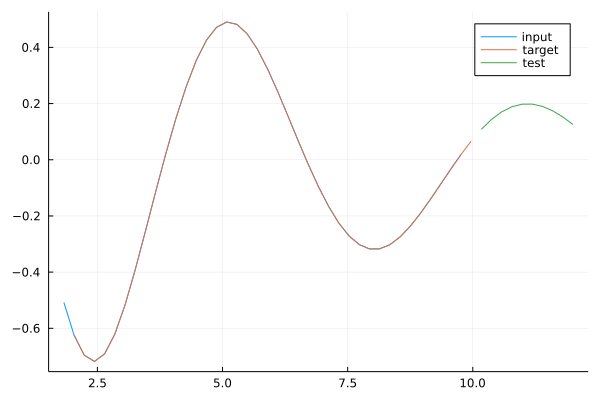

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [38]:
plot(t_input,input_data[1,:],label = "input")
plot!(t_target,target_data[1,:],label = "target")
plot!(t_test,test_data[1,:],label = "test")

In [39]:
using ReservoirComputing
res_size = 10
res_radius = 1.0
res_sparsity = 1.0
input_scaling = 0.1

#build ESN struct
esn = ESN(input_data; 
    variation = Default(),
    reservoir = RandSparseReservoir(res_size, radius=res_radius, sparsity=res_sparsity),
    input_layer = WeightedLayer(scaling=input_scaling),
    
    nla_type = NLADefault(),
    states_type = StandardStates())

#reservoir_driver = RNN(),

ESN{Int64, Matrix{Float64}, Default, NLADefault, Matrix{Float64}, ReservoirComputing.RNN{typeof(tanh_fast), Float64}, Matrix{Float64}, Matrix{Float64}, StandardStates, Int64, Matrix{Float64}}(10, [-0.5078395903404999 -0.6242590722210379 … -0.033469099249182226 0.018301528639352048; -0.673128935803847 -0.4688501586240812 … 0.2536844460458576 0.23839018517401075], Default(), NLADefault(), [0.03168270838016443 0.0; -0.08268329865968249 0.0; … ; 0.0 0.03526234751476051; 0.0 -0.061846527660723294], ReservoirComputing.RNN{typeof(tanh_fast), Float64}(NNlib.tanh_fast, 1.0), [-0.42971482095011404 0.2493731570600523 … -0.3846095104673922 0.4477766924197807; -0.44715407065446916 -0.07065956177381261 … -0.3361757713889389 -0.17696367545140576; … ; -0.20826304783882707 -0.16486083162871673 … 0.23582044125512058 -0.3250633196143105; -0.20990591169664333 0.457206665246617 … -0.322519910821286 -0.09516378637637513], [0.0; 0.0; … ; 0.0; 0.0;;], StandardStates(), 0, [-0.016088345354198792 0.008588346917

In [40]:
#define training method
training_method = StandardRidge(0.0)

#obtain output layer
output_layer = train(esn, target_data, training_method)

OutputLayer{StandardRidge{Float64}, Adjoint{Float64, Matrix{Float64}}, Int64, Vector{Float64}}(StandardRidge{Float64}(0.0), [5.652129794779804 -1.3983200407749874 … 7.817570586709977 -8.358876494629955; -4.6494419829983045 8.412985173698823 … 1.4390637434024203 -0.05288730139896986], 2, [0.06610905869261414, 0.21552086952468677])

In [41]:
output1 = esn(Generative(predict_len), output_layer)

2×10 Matrix{Float64}:
 0.106048  0.138573  0.163053   …   0.147733   0.122011   0.0929194
 0.180927  0.141142  0.0958564     -0.113799  -0.138224  -0.153988

In [42]:
using Plots, Plots.PlotMeasures



In [43]:
test_data

2×10 Matrix{Float64}:
 0.108244  0.143351  0.170372  0.188623   …   0.17442     0.15254    0.125719
 0.185626  0.150565  0.111577  0.0702525     -0.0853641  -0.114258  -0.137083

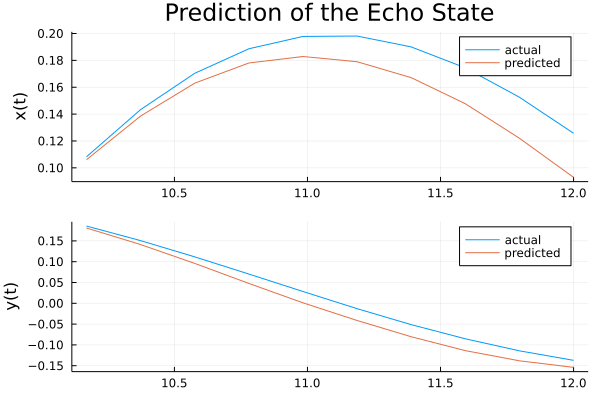

base64 binary data: b3BlbjogTm8gc3VjaCBmaWxlIG9yIGRpcmVjdG9yeQpvcGVuOiBObyBzdWNoIGZpbGUgb3IgZGlyZWN0b3J5CkdLUzogZmlsZSBvcGVuIGVycm9yIChDOlxVc2Vyc1zW3MzsuuNcLmp1bGlhXGFydGlmYWN0c1xjOTM1MTE2YzljN2I5MWI0ZjI3YmEyYjNjOWY3YzZiNjM5YjMwMmFjXGJpblwuLlxGT05UU1xHS1NGT05ULkRBVCkKR0tTOiBmaWxlIG9wZW4gZXJyb3IgKEM6XFVzZXJzXNbczOy641wuanVsaWFcYXJ0aWZhY3RzXGM5MzUxMTZjOWM3YjkxYjRmMjdiYTJiM2M5ZjdjNmI2MzliMzAyYWNcYmluXC4uXEZPTlRTXEdLU0ZPTlQuREFUKQo=


In [44]:
p1 = plot(t_test, [test_data[1,:] output1[1,:]], label = ["actual" "predicted"], 
    ylabel = "x(t)");



p2 = plot(t_test, [test_data[2,:] output1[2,:]], label = ["actual" "predicted"], 
    ylabel = "y(t)");


plot(p1, p2, plot_title = "Prediction of the Echo State", 
    layout=(2,1))

In [45]:
#Different Noise level
# function loss_function(data, pred)
#     return sum(abs2, data - pred)
# end

# function plot_multiple_shoot(plt, preds, group_size,datasize,group_size,data)
#     step = group_size-1
#     ranges = DiffEqFlux.group_ranges(datasize, group_size)
    
#     plt = scatter(tsteps, sol[1,:], label = "Data")

#     for (i, rg) in enumerate(ranges)
#         plot!(plt, tsteps[rg], preds[i][1,:], markershape=:circle, label="Group $(i)")
#     end
# end





In [ ]:
# anim = Plots.Animation()
# iter = 0
# callback = function (p, l, preds; doplot = true)
#   display(l)
#   global iter
#   iter += 1
#   if doplot && iter%1 == 0
#     # plot the original data
#     plt = scatter(tsteps, sol[1,:], label = "Data")

#     # plot the different predictions for individual shoot
#     plot_multiple_shoot(plt, preds, group_size)

#     frame(anim)
#     display(plot(plt))
#   end
#   return false
# end



# function train_and_test_multiple_shoot(original_data,noise_data,nn,datasize,timespan,initial_condition,group_size = 3,
# continuity_term = 200)
#     rng = Random.default_rng()
#     p_init, st = Lux.setup(rng, nn)
#     tsteps = range(timespan[1],timespan[2],length=datasize)
#     neuralode = NeuralODE(nn, timespan, Tsit5(), saveat = tsteps)
    
#     prob_node = ODEProblem((u,p,t)->nn(u,p,st)[1], initial_condition, timespan, Lux.ComponentArray(p_init))
    
#     #Multiple Shoot Loss
#     loss_multiple_shooting = multiple_shoot(p, original_data, tsteps, prob_node, loss_function, Tsit5(),
#                           group_size; continuity_term)
    

    
    
# end
    

## 2. But in reality, we don't have the 